#Cross Attention:
  **Image and Text or simply the given description of those images are quite difficult to comprehend, as text is an unstructured time series data. To simply put it in a prospect, a simple image might consist of many things, that is mountains, or even children playing in the background or even the cars in the far vicinity. I have come up with an idea to generate description of contents of the image, from the images itself. For this we could use attention mechanism, where a particular area of the input sequence is given more attention than other particular areas. This particular area of high importance is calculated by the dot products between the two vector embeddings (in case of cross attention), and learning about this area is done by iterative processes. Dot products are then usually scaled up and passesd through a softmax function to obtain the attention weights, representing the context of the particular token with the vector embeddings of images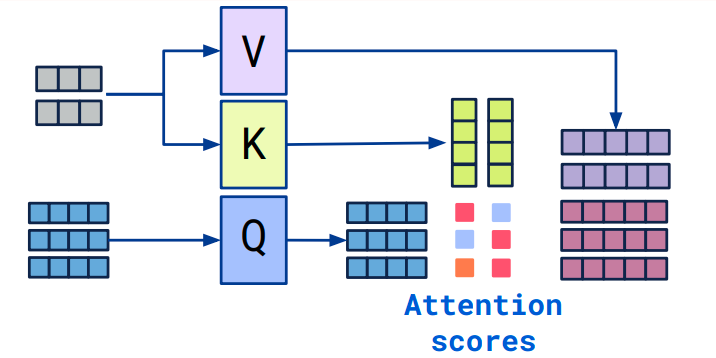.**

**Here key and values are vector embeddings for image, obtained after passing through the linear layer, and query is vector embedding of those prompts that are attached with the images while training. We need to find the similar vector embeddings between the image and prompt or text, by the dot product operation.**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
import numpy as np
import pandas as pd
import math
import os
import torchvision
from torchvision import datasets, transforms
import os
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
# import torchvision.transforms as T
# transform = T.Resize((28, 28))

# Dot Product Initial Code

**This is the initial code for reference of attention layer, where vector embeddings are passed through a linear layer to produce query, key and value matrix.**

**Query:** *For the query, it represents the sequence of tokens for which we want to calculate the attention scores. I have kept it as the vector embeddings for a given prompt.*

**Key**: *It consists of sequence of tokens against which we compute the similar values for query matrix. The dot product is calculate between key and query matrix, to give out the similar vector embeddings among the matrix.*

**Value**: *It is the actual representation or content and is derived from the input embeddings.*

In [ ]:
# This is just a demo for cross attention calculation I have used the same way to calculate the
# cross attention of the image and text.

class CrossAttention(nn.Module):
  def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
    super().__init__()
    self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
    self.k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
    self.v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
    self.out_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
    self.n_heads = n_heads
    self.d_head = d_embed // n_heads
  def forward(self, x, y):
    input_shape = x.shape
    batch_size, sequence_length, d_embed = input_shape
    interim_shape = (batch_size, -1, self.n_heads, self.d_head)
    q = self.q_proj(x)
    k = self.k_proj(y)
    v = self.v_proj(y)
    q = q.view(interim_shape).tranpose(1, 2)
    k = k.view(interim_shape).transpose(1, 2)
    v = v.view(interim_shape).transpose(1, 2)
    weight = q @ k.transpose(-1, -2)
    weight /= math.sqrt(self.d_head)
    weight = F.softmax(weight, dim=-1)
    output = weight @ v
    output = output.view(input_shape)
    output = self.out_proj(output)
    return output

#Let's deal with the text first

**I have use the data from hugging face library for dataset, downloaded it and convert it into the size of 224, 224 and the given prompt**

In [ ]:
with open("/content/drive/MyDrive/Text_to_image(text)/Text/descrition.txt", "r", encoding="utf-8") as f:
  text = f.read()

In [ ]:
text_list = text.split('\n')

In [ ]:
list(text_list)

['photo of kirby from nintendo in casual clothes, pink kirby walking, kirby walking down the street in casual clothes, he looks cool, he is holding a yo-yo',
 'Nicolas cage as Norman Osborn',
 'Nicolas Cage as the Green Goblin',
 'Nicolas Cage as the Green Goblin',
 'abstract art representing momentum, oil painting by john berkey and gabriel dawe, masterwork',
 'Mads Mikkelsen as the hobgoblin',
 'Nicolas Cage starring in Saving private Ryan',
 'priyanaka chopra',
 'Photo of Jennifer Gardner wearing Warby Parker glasses, soft studio lighting, photo taken by Martin Schoeller for Abercrombie and Fitch, award-winning photo, 24mm f/1.4',
 'a hearse designed by Porsche',
 'Photo of Emma Stone wearing Warby Parker glasses, soft studio lighting, photo taken by Martin Schoeller for Abercrombie and Fitch, award-winning photo, 24mm f/1.4',
 'Horror film still frame. The grotesque creature waits patiently in the shadows as their victim approaches. Cinematic, Award winning, ultra high resolution, 

In [ ]:
text[0]

'p'

**Let's find out the vocab size**

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !&'()+,-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ\_abcdefghijklmnopqrstuvwxyz| Éåéíïùłń‍–“”•❤⭐️🐇🐮👨👽😉🚀🤖🥕
104


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_batch(split):
  data = split

  x = data[0:len(data)-1]
  y = data[1:i+len(data[i])]
  x, y = x.to(device), y.to(device)
  return x, y

In [ ]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l])

In [ ]:
len(text_list)

1001

In [ ]:
text_list = text_list[:50]

In [ ]:
print(len(text_list))

100


In [ ]:
n = int(0.9 * len(text_list))
val_data = text_list[n:]
train_data = text_list[:n]


In [ ]:
text_list[2]

'Nicolas Cage as the Green Goblin'

In [ ]:
text_list_1 = []
for i in range(len(text_list)):
  data = torch.tensor(encode(text_list[0]), dtype = torch.long)
  text_list_1.append(data)

In [ ]:
n = int(0.9 * len(text_list_1))
train_data = text_list_1[:n]
valid_data= text_list_1[n:]

In [ ]:
train_data[0]

tensor([67, 59, 66, 71, 66,  1, 66, 57,  1, 62, 60, 69, 53, 76,  1, 57, 69, 66,
        64,  1, 65, 60, 65, 71, 56, 65, 55, 66,  1, 60, 65,  1, 54, 52, 70, 72,
        52, 63,  1, 54, 63, 66, 71, 59, 56, 70,  8,  1, 67, 60, 65, 62,  1, 62,
        60, 69, 53, 76,  1, 74, 52, 63, 62, 60, 65, 58,  8,  1, 62, 60, 69, 53,
        76,  1, 74, 52, 63, 62, 60, 65, 58,  1, 55, 66, 74, 65,  1, 71, 59, 56,
         1, 70, 71, 69, 56, 56, 71,  1, 60, 65,  1, 54, 52, 70, 72, 52, 63,  1,
        54, 63, 66, 71, 59, 56, 70,  8,  1, 59, 56,  1, 63, 66, 66, 62, 70,  1,
        54, 66, 66, 63,  8,  1, 59, 56,  1, 60, 70,  1, 59, 66, 63, 55, 60, 65,
        58,  1, 52,  1, 76, 66,  9, 76, 66])

#Now let's convert our list to batches

In [ ]:
def generate_batches(data, batch_size):

    num_batches = len(data) // batch_size
    batches = []


    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch_data = data[batch_start:batch_end]
        batches.append(batch_data)


    if len(data) % batch_size != 0:
        last_batch = data[num_batches * batch_size:]
        batches.append(last_batch)

    return batches

In [ ]:
train_batches = generate_batches(train_data, 5)

In [ ]:
len(train_batches)

18

In [ ]:
train_batches[0]

[tensor([67, 59, 66, 71, 66,  1, 66, 57,  1, 62, 60, 69, 53, 76,  1, 57, 69, 66,
         64,  1, 65, 60, 65, 71, 56, 65, 55, 66,  1, 60, 65,  1, 54, 52, 70, 72,
         52, 63,  1, 54, 63, 66, 71, 59, 56, 70,  8,  1, 67, 60, 65, 62,  1, 62,
         60, 69, 53, 76,  1, 74, 52, 63, 62, 60, 65, 58,  8,  1, 62, 60, 69, 53,
         76,  1, 74, 52, 63, 62, 60, 65, 58,  1, 55, 66, 74, 65,  1, 71, 59, 56,
          1, 70, 71, 69, 56, 56, 71,  1, 60, 65,  1, 54, 52, 70, 72, 52, 63,  1,
         54, 63, 66, 71, 59, 56, 70,  8,  1, 59, 56,  1, 63, 66, 66, 62, 70,  1,
         54, 66, 66, 63,  8,  1, 59, 56,  1, 60, 70,  1, 59, 66, 63, 55, 60, 65,
         58,  1, 52,  1, 76, 66,  9, 76, 66]),
 tensor([67, 59, 66, 71, 66,  1, 66, 57,  1, 62, 60, 69, 53, 76,  1, 57, 69, 66,
         64,  1, 65, 60, 65, 71, 56, 65, 55, 66,  1, 60, 65,  1, 54, 52, 70, 72,
         52, 63,  1, 54, 63, 66, 71, 59, 56, 70,  8,  1, 67, 60, 65, 62,  1, 62,
         60, 69, 53, 76,  1, 74, 52, 63, 62, 60, 65, 58,  8,  

#Now let's focus on our image model

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

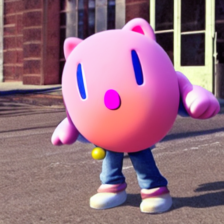

In [ ]:
Image.open("/content/drive/MyDrive/Text_to_image(text)/Image/image_0.png")

In [ ]:
image_data_path = "/content/drive/MyDrive/Text_to_image(text)/Image/"
images = []
for i in range(100):
  image = Image.open(f"/content/drive/MyDrive/Text_to_image(text)/Image/image_{i}.png")
  img = transform(image)

  images.append(image)


In [ ]:
images[0].size

(224, 224)

Text(0.5, 1.0, 'photo of kirby from nintendo in casual clothes, pink kirby walking, kirby walking down the street in casual clothes, he looks cool, he is holding a yo-yo')

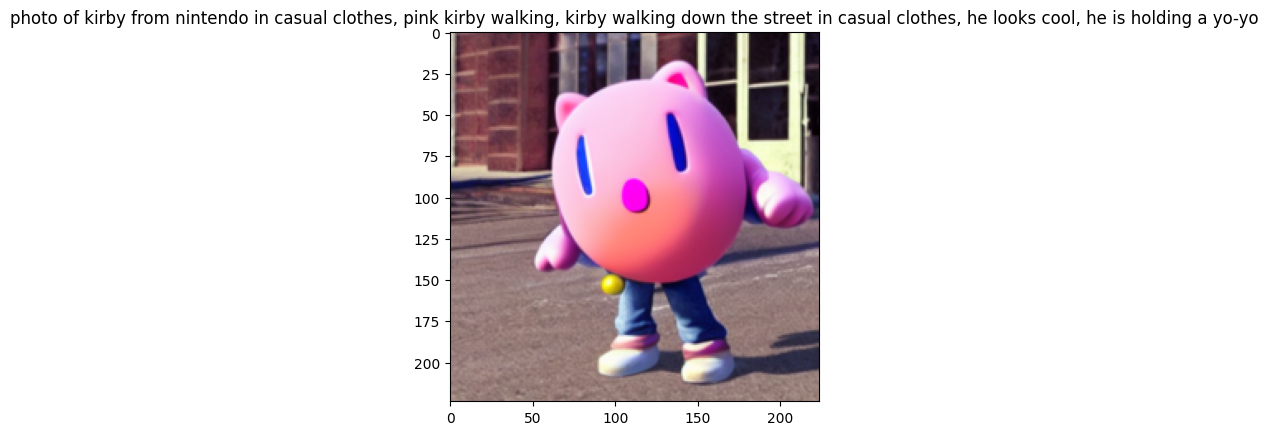

In [ ]:
#Image and text is as shown below
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.title(text_list[0])

In [ ]:
print(text_list[0])

photo of kirby from nintendo in casual clothes, pink kirby walking, kirby walking down the street in casual clothes, he looks cool, he is holding a yo-yo


In [ ]:
@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'val']:
    loss = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, y = get_batch(split)
      logits, loss = model(X, y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [ ]:
train_batches[0][0]

tensor([67, 59, 66, 71, 66,  1, 66, 57,  1, 62, 60, 69, 53, 76,  1, 57, 69, 66,
        64,  1, 65, 60, 65, 71, 56, 65, 55, 66,  1, 60, 65,  1, 54, 52, 70, 72,
        52, 63,  1, 54, 63, 66, 71, 59, 56, 70,  8,  1, 67, 60, 65, 62,  1, 62,
        60, 69, 53, 76,  1, 74, 52, 63, 62, 60, 65, 58,  8,  1, 62, 60, 69, 53,
        76,  1, 74, 52, 63, 62, 60, 65, 58,  1, 55, 66, 74, 65,  1, 71, 59, 56,
         1, 70, 71, 69, 56, 56, 71,  1, 60, 65,  1, 54, 52, 70, 72, 52, 63,  1,
        54, 63, 66, 71, 59, 56, 70,  8,  1, 59, 56,  1, 63, 66, 66, 62, 70,  1,
        54, 66, 66, 63,  8,  1, 59, 56,  1, 60, 70,  1, 59, 66, 63, 55, 60, 65,
        58,  1, 52,  1, 76, 66,  9, 76, 66])

In [ ]:
class Image_Embeddings(nn.Module):
  def __init__(self, vocab_size, num_channels=3):
    super().__init__()
    self.vocab_size = vocab_size

    # self.num_channels = num_channels

    self.projection = nn.Conv2d(num_channels, vocab_size, kernel_size=2)

    self.dropout = nn.Dropout(0.0)
  def forward(self, x):
    if len(x.shape) == 3:

      x =  x.unsqueeze(0)
    x = self.projection(x)
    x = x.flatten(2).transpose(1, 2)

    x = x + self.dropout(x)
    return x




#Now let's work on a solution to combine both

**Here, the image embedding is the query, text embedding is the key and value, as we need to predict the text.**

#Head

In [ ]:
hidden = 16
dropout = 0.0
learning_rate = 1e-3
max_iters = 100
eval_iters = 10
n_embed = 224*224
num_channels = 3


#Workflow:
**let us imagine we give a text and image to this program, both has some kind of features which relates to each other. Our main task is to take out this feature, and to get that important feature out of the input image and find out how it relates to the text. For this we supply the prompt or text which describes the content of that image. Both of them are passed through the embedding layer.**

**In image embedding layer we use convolutional layer and projection layer to make the output as the prompt, that is with the same dimension as of prompt. Here in order to make the prompt as of the same dimension as image embedding, we keep embedding layer of both as DXhw, where D is the vocab size of the layer, and hw is the embedding hidden vector representation, wher hw, is the product of height and widht of the image.**

**As we multiply this embedding layer of q and k, after passing through the query and key. The concept used here is that of transformer, where we have used to find the vector embeddings of t+1 step by the use of vectors embeddings of 0 to t step and masking it up and filling up with the predicted value and compairing it with the real value for training. This is how with the use of embeddings and cross attention we were able to predict the next time sequence output.**

**Mostly in stable diffusion case we use cross attention in U-net model after image has been through encoder model, but in this we just wanted to relate the similar vectors between image and text. So, I have used projected layer from convolutional network for image and embedding layer for text, for linear in q, k and v matrix.**

In [ ]:
class Head(nn.Module):
  def __init__(self, n_embed, hidden):
    super().__init__()
    self.query = nn.Linear(n_embed, hidden, bias=False)
    self.key = nn.Linear(n_embed, hidden, bias=False)
    self.value = nn.Linear(n_embed, hidden, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(n_embed, n_embed)))
    self.dropout = nn.Dropout(dropout)
  def forward(self, x, y):
    B, T, C = x.shape
    q = self.query(x)
    k = self.key(y)
    wei = q@k.transpose(-2, -1) * C ** -0.5
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
    wei = F.softmax(wei, dim=-1)
    wei = self.dropout(wei)
    v = self.value(y)
    out = wei@v
    return out




#Mutihead Attention:
**As one head layer can only focus on some part of the image and text, I have used 12 heads to find out almost all the relationship between image and text and finding out the common relationship between them**

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, n_embed):
    super().__init__()
    self.heads = nn.ModuleList([Head(n_embed, hidden) for _ in range(12)])
    self.proj = nn.Linear(n_embed, n_embed)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x, y):
    out = torch.cat([h(x, y) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out


In [ ]:

class FeedFoward(nn.Module):


    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):


    def __init__(self, n_embed):

        super().__init__()

        self.sa = MultiHeadAttention(n_embed)
        self.ffwd = FeedFoward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x, y):
        b = self.sa(x, y)
        a = self.ln1(b+x+y)
        b = self.ffwd(a)
        x = self.ln2(a+b)

        return x

#Cross Attention Layer:
Here both prompt and image embedding is generated and passed it throught the block to multihead attention layer, we have used it to normalize the final output from transformer block, and also generates the token prediction using the linear layer.

In [ ]:
class CrossAttentionLayer(nn.Module):
  def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_hw)
        self.visual_embedding_table = Image_Embeddings(vocab_size)

        self.blocks = nn.Sequential(*[Block(n_embed)])
        self.ln_f = nn.LayerNorm(n_embed) # final layer norm
        self.lm_head = nn.Linear(n_embed, vocab_size)
  def forward(self, idx=None, image, targets=None):
        B, T = image.shape

        # idx and targets are both (B,T) tensor of integers

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        vis_emb = self.visual_embedding_table(image)

        x = tok_emb
        y = vis_emb
        x = self.blocks(x, y) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)




        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
#We use both image and tokens for the predictions of the next output in a masked fill approach described above

  def generate(self, idx, image, max_new_tokens):

        for _ in range(max_new_tokens):



          #Give both images and the prompt to out block layer
            logits, loss = self(idx, images)
          #Focus only on the final output
            logits = logits[:, -1, :]
          #Use softmax to find out the probability of weight of the past vectors for further calculation. The past vectors can be utilized as weight matrix.
            probs = F.softmax(logits, dim=-1)
        # Use multinomial distribution function from pytorch to sample from the multinomial distribution function.
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        #Concatenate the previous and next output and try to predict the output one word at a time.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
n_hw = 224*224

In [ ]:
model = CrossAttentionLayer()
m = model.to(device)


#Let's train our model


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
for iter in range(max_iters):
  if iter % eval_iters == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

  xb, yb = get_batch(train_data[iter])
  logits, loss = model(xb, image[iter], yb)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


**Let's generate some text from the image**

**We give a random image and a tensor that is 0. we try to generate the context or vectors which relates to the image. Maximum number of tokens we want to generate is 20 describing the contents of the image.**

In [ ]:
#Let me give some context of both image and starting intial 0 as
image = Image.open("/content/drive/MyDrive/Text_to_image(text)/Image/image_120.png")
context = torch.zeros((1, 1), dtype=torch.long, device)
print(decode(m.generate(context, image, max_new_tokens=20)))[0].tolist()

**Because of lack of resources I am not able to run this on my own computer, but I am trying to run it on my college computer as soon as I get the permission to use it. Meanwhile I came up with this solution. You could mail me for any advice, I would be really happy to listen to you advice and work on the problems I might encounter training it.**